In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
import xgboost as xgb
from sklearn.metrics import mean_squared_error

In [23]:
energy_df = pd.read_csv('data/energy/AEP_hourly.csv', 
                        parse_dates=['Datetime'], 
                        index_col='Datetime')
energy_df = energy_df.sort_index()
energy_df.head()

,AEP_MW
Datetime,
2004-10-01 01:00:00,12379.0
2004-10-01 02:00:00,11935.0
2004-10-01 03:00:00,11692.0
2004-10-01 04:00:00,11597.0
2004-10-01 05:00:00,11681.0


In [24]:
print("NULL Values:")
print(energy_df.isnull().sum())

NULL Values:
AEP_MW    0
dtype: int64


In [25]:
energy_df.describe()

,AEP_MW
count,121273.000000
mean,15499.513717
std,2591.399065
min,9581.000000
25%,13630.000000
50%,15310.000000
75%,17200.000000
max,25695.000000


In [26]:
print("Earliest Date:", energy_df.index.min())
print("Latest Date:", energy_df.index.max())

Earliest Date: 2004-10-01 01:00:00
Latest Date: 2018-08-03 00:00:00


In [27]:
def create_features(df):
    df = df.copy()
    df['hour'] = df.index.hour
    df['day_of_week'] = df.index.dayofweek
    df['month'] = df.index.month
    df['quarter'] = df.index.quarter
    df['year'] = df.index.year
    df['day_of_year'] = df.index.dayofyear
    df['day_of_month'] = df.index.day
    df['week'] = df.index.isocalendar().week
    return df

In [28]:
df = create_features(energy_df)

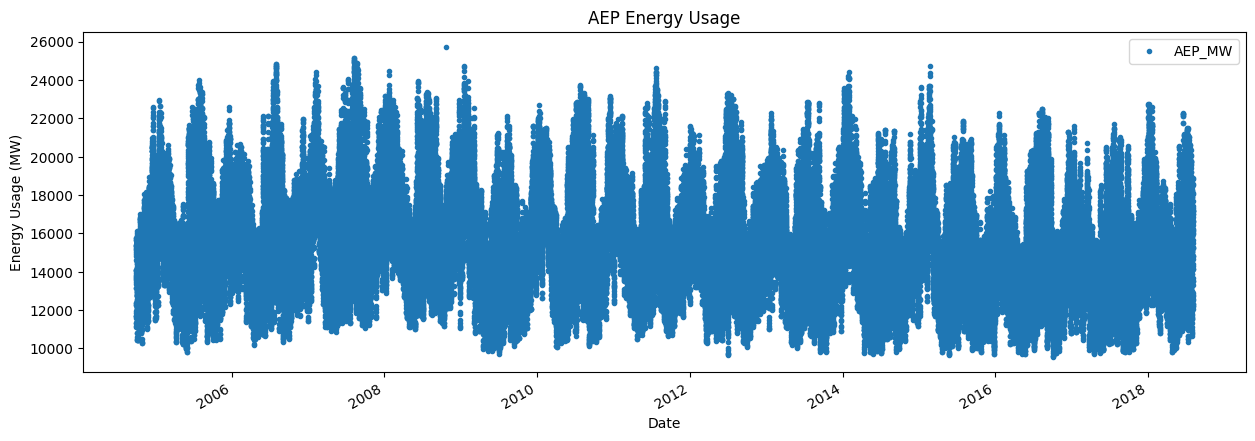

In [29]:
df.plot(y='AEP_MW',
        figsize=(15,5),
        title="AEP Energy Usage",
        style='.')
plt.ylabel('Energy Usage (MW)')
plt.xlabel('Date')
plt.show()

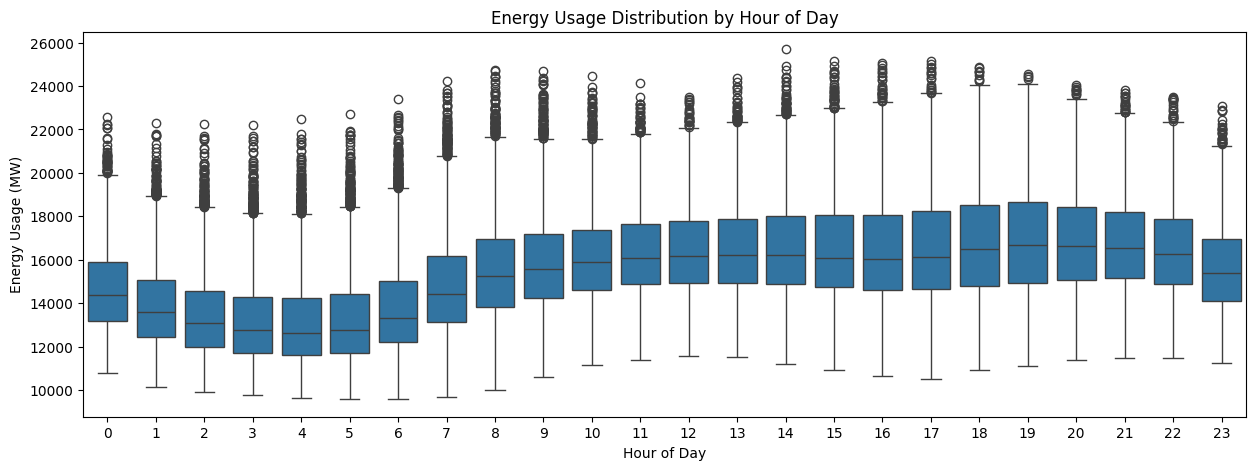

In [30]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.boxplot(x=df['hour'], y=df['AEP_MW'], ax=ax)
plt.title("Energy Usage Distribution by Hour of Day")
plt.ylabel('Energy Usage (MW)')
plt.xlabel('Hour of Day')
plt.show()

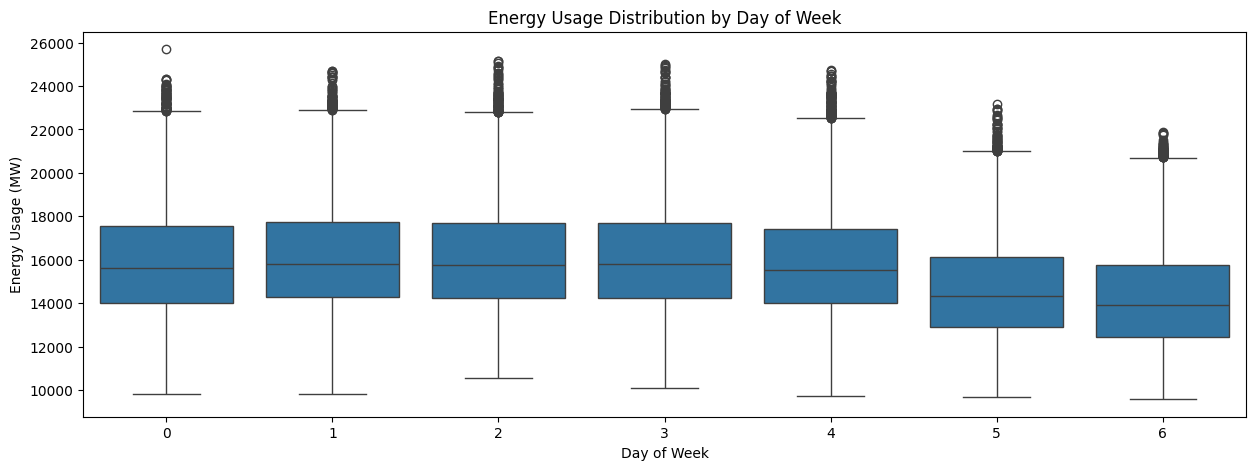

In [31]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.boxplot(x=df['day_of_week'], y=df['AEP_MW'], ax=ax)
plt.title("Energy Usage Distribution by Day of Week")
plt.ylabel('Energy Usage (MW)')
plt.xlabel('Day of Week')
plt.show()

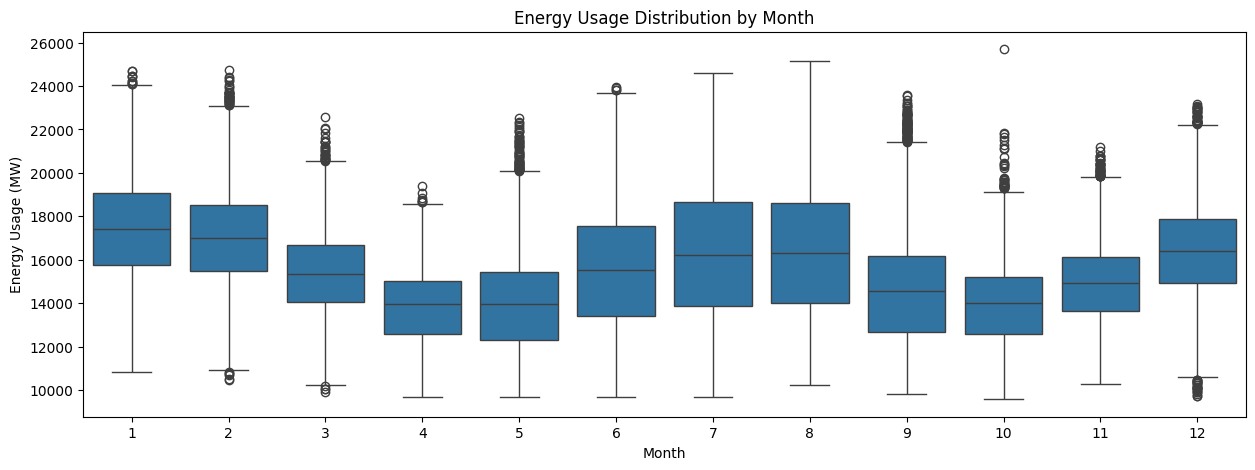

In [32]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.boxplot(x=df['month'], y=df['AEP_MW'], ax=ax)
plt.title("Energy Usage Distribution by Month")
plt.ylabel('Energy Usage (MW)')
plt.xlabel('Month')
plt.show()

In [33]:
# Split the data into training and testing sets (80% train:20% test)
train, test = train_test_split(df, test_size=0.2, shuffle=False)
print(f"Training set range: {train.index.min()} -> {train.index.max()}")
print(f"Testing set range: {test.index.min()} -> {test.index.max()}")

# Divide the train/test sets into features(X) and target(y)
X_train = train.drop('AEP_MW', axis=1)
y_train = train['AEP_MW']
X_test = test.drop('AEP_MW', axis=1)
y_test = test['AEP_MW']

Training set range: 2004-10-01 01:00:00 -> 2015-10-27 09:00:00
Testing set range: 2015-10-27 10:00:00 -> 2018-08-03 00:00:00


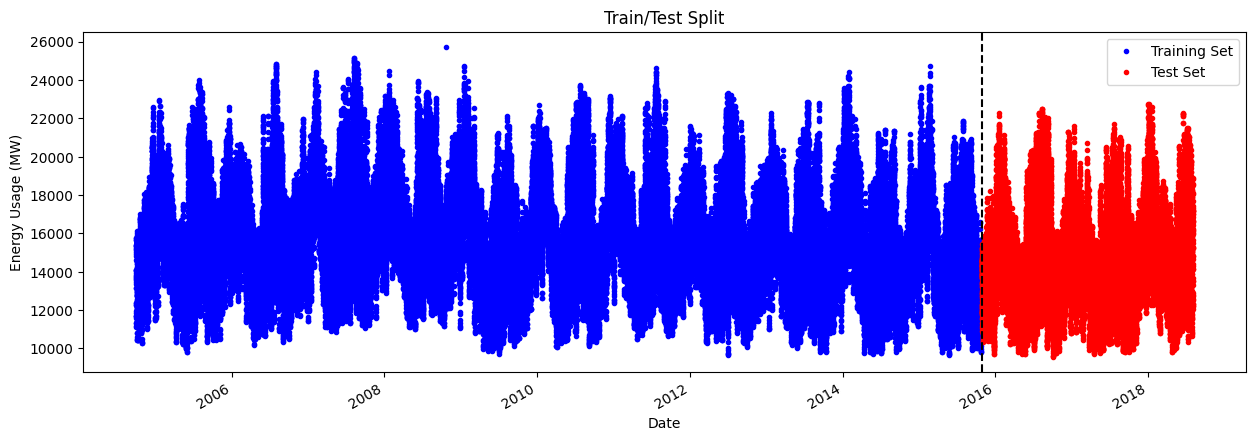

In [34]:
fig, ax = plt.subplots(figsize=(15, 5))
train.plot(y='AEP_MW', ax=ax, label='Train Set', style='.', color='blue')
test.plot(y='AEP_MW', ax=ax, label='Test Set', style='.', color='red')
plt.title("Train/Test Split")
plt.ylabel('Energy Usage (MW)')
plt.xlabel('Date')
plt.legend(['Training Set', 'Test Set'])
plt.axvline(x=test.index.min(), color='black', linestyle='--' , label='Train/Test Split')
plt.show()

In [35]:
xgb_model = xgb.XGBRegressor(objective='reg:squarederror',
                             n_estimators=1000, 
                             early_stopping_rounds=None, 
                             learning_rate=0.01,
                             random_state=11)

xgb_param_grid = {
    'n_estimators': [100, 500, 1000],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'min_child_weight': [1, 5, 10]
}

tscv = TimeSeriesSplit(
    n_splits=5,
    gap=7
)

xgb_grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=xgb_param_grid,
    scoring='neg_mean_squared_error',
    cv=tscv,
    n_jobs=-1,
    verbose=2
)

xgb_grid_search.fit(X_train, y_train)

print(f"Best Parameters: {xgb_grid_search.best_params_}")
print(f"Best Score: {xgb_grid_search.best_score_}")

Fitting 5 folds for each of 81 candidates, totalling 405 fits
Best Parameters: {'learning_rate': 0.01, 'max_depth': 5, 'min_child_weight': 5, 'n_estimators': 500}
Best Score: -2573531.265170532


In [36]:
best_xgb_model = xgb_grid_search.best_estimator_
y_pred = best_xgb_model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"XGB Test Set RMSE: {rmse:.4f}")

XGB Test Set RMSE: 1699.4110


In [37]:
test['prediction'] = y_pred
df = df.merge(test[['prediction']], how='left', left_index=True, right_index=True)

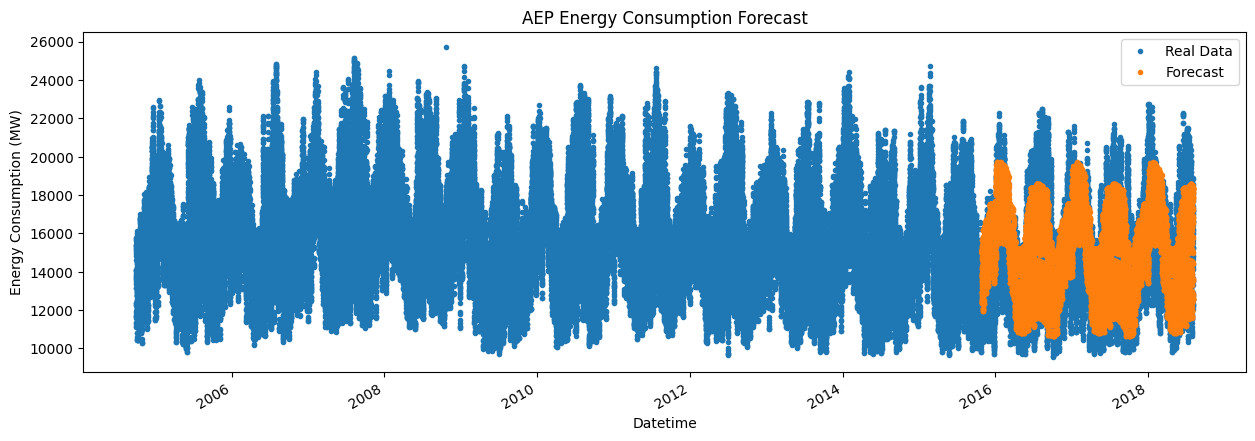

In [ ]:
ax = df[['AEP_MW']].plot(figsize=(15,5),
                         style='.')
df['prediction'].plot(ax=ax, style='.')
ax.set_title('AEP Energy Consumption Forecast (XGBoost)')
ax.set_ylabel('Energy Consumption (MW)')
plt.legend(['Real Data','Forecast'])
plt.show()